In [108]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax.experimental.ode import odeint
import optax

from flax import linen as nn
from flax.training import train_state
from jax import random

import matplotlib.pyplot as plt
import sys
import os
import time

path_ = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if path_ not in sys.path:
    sys.path.append(path_)

from non_parametric_collocation import collocate_data
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data

In [102]:
# data
n_points = 200
ode_type = "harmonic_oscillator"
params = {"omega_squared": 1}
start_time=0
end_time=10
spacing_type="equally_spaced"
initial_state = jnp.array([0.0, 1.0])
noise_level = 0.0
    
# generate data for the according noise level
t, y, y_noisy, true_derivatives = generate_ode_data(n_points, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

In [103]:
class NeuralODE_Collocation(nn.Module):
    """
    A neural network model for approximating ODE solutions using collocation.
    
    Attributes:
        layer_widths (list): List of integers specifying the width of each layer in the neural network.
    """
    layer_widths: list

    @nn.compact
    def __call__(self, y):
        """
        Forward pass through the neural network.        
        Args:

        Returns:
            jax.numpy.ndarray: Output of the neural network.
        """
        for width in self.layer_widths[:-1]:
            y = nn.Dense(width)(y)
            y = nn.tanh(y)
        y = nn.Dense(self.layer_widths[-1])(y)
        return y
    
    
def create_train_state_collocation(rng, layer_widths, input_shape, learning_rate):
    """
    Create and initialize the training state for the model.
    
    Args:
        rng (jax.random.PRNGKey): Random number generator key.
        layer_widths (list): List of integers specifying the width of each layer in the neural network.
        input_shape (tuple): Shape of the input data.
        learning_rate (float): Learning rate for the optimizer.
    
    Returns:
        train_state.TrainState: Initialized training state.
    """
    model = NeuralODE_Collocation(layer_widths=layer_widths)
    u_init, v_init = 1.0, 1.0
    y_init = jnp.array([u_init, v_init])
    params = model.init(rng, y_init)['params']
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)


def loss_fn_collocation(params, apply_fn, y_init, observed_derivative, observed_data):
    """
    Compute the loss as the mean absolute error between predicted and observed derivatives.
    
    Args:
        params (dict): Parameters of the model.
        apply_fn (function): Function to apply the model to input data.
        y_init
        observed_derivative (jax.numpy.ndarray): True derivatives at the input features.
    
    Returns:
        float: The mean absolute error loss.
    """
    pred_derivatives = []
    for data in observed_data:
        pred_derivative = apply_fn({'params': params}, data)
        pred_derivatives.append(pred_derivative)
        
    return jnp.mean(jnp.abs(jnp.array(pred_derivatives) - observed_derivative))

@jit
def train_step_collocation(state, y_init, observed_derivative, observed_data):
    """
    Perform a single training step by computing the loss and its gradients,
    and then updating the model parameters.

    Args:
        state (train_state.TrainState): Contains model state including parameters.
        u (jax.numpy.ndarray): Input data for u.
        v (jax.numpy.ndarray): Input data for v.
        observed_derivative (jax.numpy.ndarray): True derivatives to compare against model predictions.

    Returns:
        tuple: Updated state and loss value.
    """
    def loss_fn(params):
        return loss_fn_collocation(params, state.apply_fn, y_init, observed_derivative, observed_data)
    
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss

def train_collocation(state, y_init, observed_derivative, observed_data, num_epochs=1000):
    """
    Train the model using the collocation method for a given number of epochs.
    
    Args:
        state (train_state.TrainState): Initial state of the model.
        y_init .....?
        observed_data (jax.numpy.ndarray): True derivatives to compare against model predictions.
        num_epochs (int, optional): Number of training epochs. Default is 1000.
    
    Returns:
        train_state.TrainState: Trained model state.
    """
    for epoch in range(num_epochs):
        state, loss = train_step_collocation(state, y_init, observed_derivative, observed_data)
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss}')
    return state

def neural_ode(state, y_init, t):
    """

    """
    def func(y, t):
        return state.apply_fn({'params': state.params}, y)
    
    return odeint(func, y_init, t)

In [104]:
layer_widths = [2, 50, 50, 2] 
learning_rate = 1e-3

# create the new state
rng = random.PRNGKey(0)
input_shape = (1, )
state = create_train_state_collocation(rng, layer_widths, input_shape, learning_rate)

In [105]:
start_timer = time.time()
# train_collocation(state_coll, t2, estimated_derivative.T, num_epochs= 10000)
t_t = jnp.array([t,t])
trained_state = train_collocation(state, initial_state, estimated_derivative.T, y_noisy, num_epochs=1000)
end_timer = time.time()
timer = end_timer - start_timer
print(f"Time elapsed: {timer}")

Epoch 0, Loss: 0.8048200607299805
Epoch 100, Loss: 0.0052711437456309795
Epoch 200, Loss: 0.0037425814662128687
Epoch 300, Loss: 0.005410426761955023
Epoch 400, Loss: 0.00716630183160305
Epoch 500, Loss: 0.0031658117659389973
Epoch 600, Loss: 0.0038497087080031633
Epoch 700, Loss: 0.003796593751758337
Epoch 800, Loss: 0.003988324664533138
Epoch 900, Loss: 0.005335665307939053
Time elapsed: 28.463299036026


In [106]:
t_test, y_test, _, _ = generate_ode_data(n_points*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

# generate predictions
y_pred = neural_ode(trained_state, initial_state, t_test)

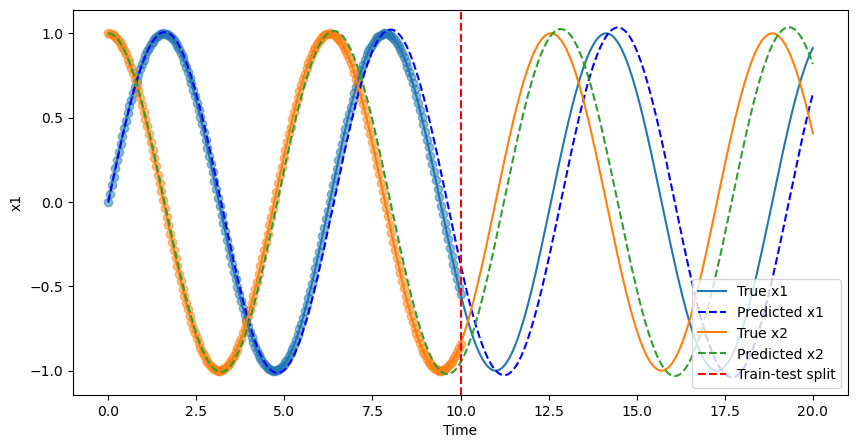

In [107]:
plt.figure(figsize=(10, 5))

plt.plot(t_test, y_test[:, 0], label='True x1')
plt.scatter(t[:200], y_noisy[:200, 0], alpha = 0.5)
plt.plot(t_test, y_pred[:, 0], 'b--', label='Predicted x1')
plt.plot(t_test, y_test[:, 1], label='True x2')
plt.plot(t_test, y_pred[:, 1], '--', label='Predicted x2')
plt.scatter(t[:200], y_noisy[:200, 1], alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('x1')
plt.axvline(x=10, color='r', linestyle='--', label='Train-test split')
plt.legend(loc='lower right')
plt.show()